In [25]:
from pyspark.sql import SparkSession
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'secrets/serviceKey.json'


# JAR paths for BigQuery and GCS connectors
bigquery_connector_jar = "spark-bigquery-connector.jar"
gcs_connector_jar = "gcs-connector.jar"


# Create SparkSession with both connectors
spark = SparkSession.builder \
    .appName("PySpark with BigQuery and GCS") \
    .config("spark.jars", f"{bigquery_connector_jar},{gcs_connector_jar}") \
    .config("spark.sql.catalog.spark_bigquery", "com.google.cloud.spark.bigquery.BigQueryCatalog") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", "secrets/serviceKey.json") \
    .config("spark.bigquery.projectId", "idmpproject-441123") \
    .getOrCreate()

spark

In [26]:
# Specify the BigQuery table
project_id = "idmpproject-441123"
dataset_id = "uberFareEstimation"
table_name = "uber_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
uber_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
uber_df.show()

+--------+--------+----------------+------------------+-------------+-----+----------------+------+--------+
|distance|cab_type|      time_stamp|       destination|       source|price|surge_multiplier|    id|    name|
+--------+--------+----------------+------------------+-------------+-----+----------------+------+--------+
|    0.94|    Uber|2018-11-28T23:30|         North End|North Station|  4.5|             1.0| 39765|UberPool|
|    0.94|    Uber|2018-12-14T19:30|         North End|North Station|  4.5|             1.0|437984|UberPool|
|    0.63|    Uber|2018-11-27T21:30|Financial District|South Station|  4.5|             1.0|  1644|UberPool|
|    0.63|    Uber|2018-12-15T15:00|Financial District|South Station|  4.5|             1.0| 10780|UberPool|
|    0.63|    Uber|2018-12-15T13:30|Financial District|South Station|  4.5|             1.0| 21598|UberPool|
|    0.63|    Uber|2018-11-28T20:30|Financial District|South Station|  4.5|             1.0| 25567|UberPool|
|    0.63|    Uber|

In [3]:
table_name = "lyft_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
lyft_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
lyft_df.show()

+--------+--------+----------------+------------------+--------------------+-----+----------------+------+------+
|distance|cab_type|      time_stamp|       destination|              source|price|surge_multiplier|    id|  name|
+--------+--------+----------------+------------------+--------------------+-----+----------------+------+------+
|     1.0|    Lyft|2018-12-02T10:30|Financial District|    Haymarket Square|  2.5|             1.0|266234|Shared|
|     1.0|    Lyft|2018-12-02T07:00|         North End|  Financial District|  2.5|             1.0|358706|Shared|
|     1.0|    Lyft|2018-12-17T02:00|Financial District|    Haymarket Square|  2.5|             1.0|401970|Shared|
|     1.0|    Lyft|2018-11-27T00:00|Financial District|    Haymarket Square|  2.5|             1.0|536179|Shared|
|     1.0|    Lyft|2018-12-16T19:00|     North Station|           North End|  2.5|             1.0|572308|Shared|
|    1.25|    Lyft|2018-12-14T09:30|          Back Bay|Northeastern Univ...|  2.5|      

In [4]:
table_name = "weather_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
weather_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
weather_df.show()

+-----+--------------------+------+--------+----+----------------+--------+-----+
| temp|            location|clouds|pressure|rain|      time_stamp|humidity| wind|
+-----+--------------------+------+--------+----+----------------+--------+-----+
|36.26|            West End|   0.0| 1012.37| 0.0|2018-11-29T18:30|    0.69| 6.84|
|29.95|         Beacon Hill|   0.0| 1015.19| 0.0|2018-12-14T18:30|    0.85| 2.43|
|29.85|   Boston University|   0.0|  1015.2| 0.0|2018-11-27T11:30|    0.85| 2.33|
|29.83|              Fenway|   0.0|  1015.2| 0.0|2018-12-16T04:30|    0.85| 2.35|
|29.99|    Haymarket Square|   0.0| 1015.19| 0.0|2018-12-17T06:30|    0.85| 2.46|
|29.95|       North Station|   0.0| 1015.19| 0.0|2018-12-03T22:00|    0.85| 2.44|
|29.88|Northeastern Univ...|   0.0|  1015.2| 0.0|2018-11-27T12:30|    0.85| 2.39|
|29.94|       South Station|   0.0| 1015.19| 0.0|2018-12-04T04:00|    0.85| 2.49|
| 29.9|    Theatre District|   0.0| 1015.19| 0.0|2018-12-17T17:00|    0.85| 2.46|
| 29.9|         

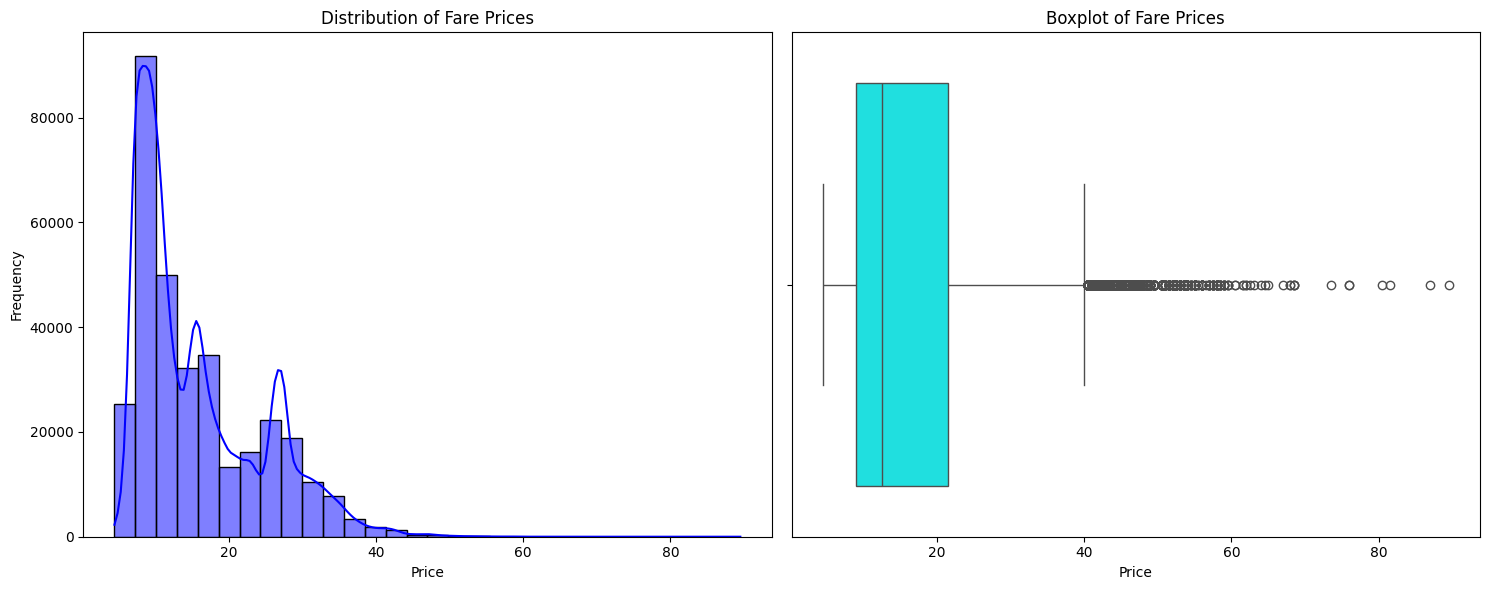

In [5]:
# Visualization 1 Fare price distribution (histogram and bar plot)

from pyspark.sql.functions import col, lit
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'price' column to Pandas for visualization
price_data_pd = uber_df.select("price").filter(col("price").isNotNull()).toPandas()

# Create a figure with two subplots: one for the histogram and one for the boxplot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram Plot
sns.histplot(price_data_pd['price'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Fare Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Boxplot Plot
sns.boxplot(x=price_data_pd['price'], color='cyan', ax=axes[1])
axes[1].set_title('Boxplot of Fare Prices')
axes[1].set_xlabel('Price')

# Display the plots
plt.tight_layout()
plt.show()


In [6]:
from pyspark.sql import functions as F

# Calculate Q1, Q3, and IQR
quantiles = uber_df.approxQuantile("price", [0.25, 0.75], 0.001)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1

# Calculate the upper bound (Q3 + 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

# Count the values beyond the upper bound
outliers_count = uber_df.filter(col("price") > upper_bound).count()

# Total number of values
total_count = uber_df.filter(col("price").isNotNull()).count()

# Calculate percentage of outliers
outliers_percentage = (outliers_count / total_count) * 100

# Print the results
print(f"Number of outliers beyond Q3 + 1.5 * IQR: {outliers_count}")
print(f"Percentage of outliers: {outliers_percentage:.2f}%")

Number of outliers beyond Q3 + 1.5 * IQR: 3015
Percentage of outliers: 0.91%


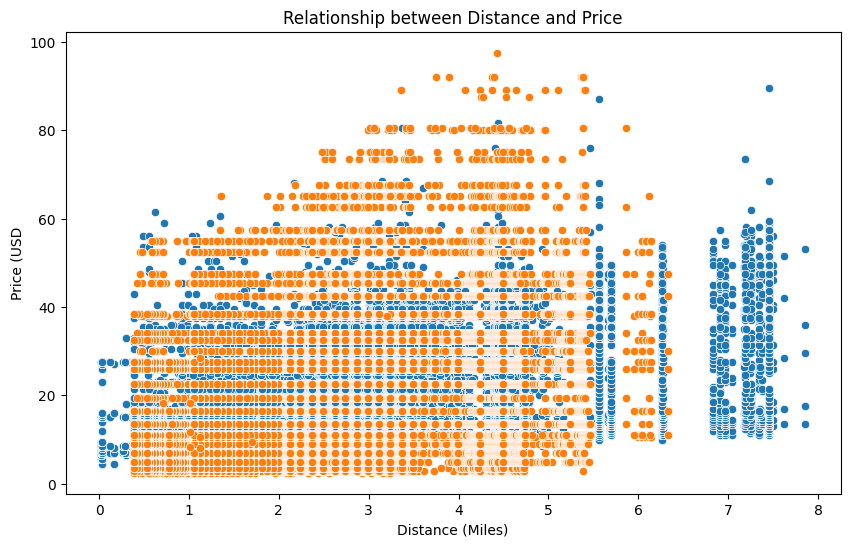

In [7]:
# Visualization 2 Distance vs Price (scatter plot)

distance_price_df_uber = uber_df.select('distance', 'price').toPandas()
distance_price_df_lyft = lyft_df.select('distance', 'price').toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=distance_price_df_uber['distance'], y=distance_price_df_uber['price'])
sns.scatterplot(x=distance_price_df_lyft['distance'], y=distance_price_df_lyft['price'])
plt.title('Relationship between Distance and Price')
plt.xlabel('Distance (Miles)')
plt.ylabel('Price (USD')
plt.show()

In [8]:
# Visualization 3 Surge Multiplier Ranges 

from pyspark.sql.functions import min, max

# Calculate minimum and maximum surge_multiplier
min_max_surge = uber_df.select(
    min("surge_multiplier").alias("min_surge"),
    max("surge_multiplier").alias("max_surge")
)

# Show the result
min_max_surge.show()

+---------+---------+
|min_surge|max_surge|
+---------+---------+
|      1.0|      1.0|
+---------+---------+



In [9]:
# Get the number of rows in the DataFrame
row_count = uber_df.count()

# Print the result
print(f"Number of rows in uber_df: {row_count}")


Number of rows in uber_df: 330568


In [10]:
# Get the number of rows in the DataFrame
row_count = weather_df.count()

# Print the result
print(f"Number of rows in uber_df: {row_count}")


Number of rows in uber_df: 4147


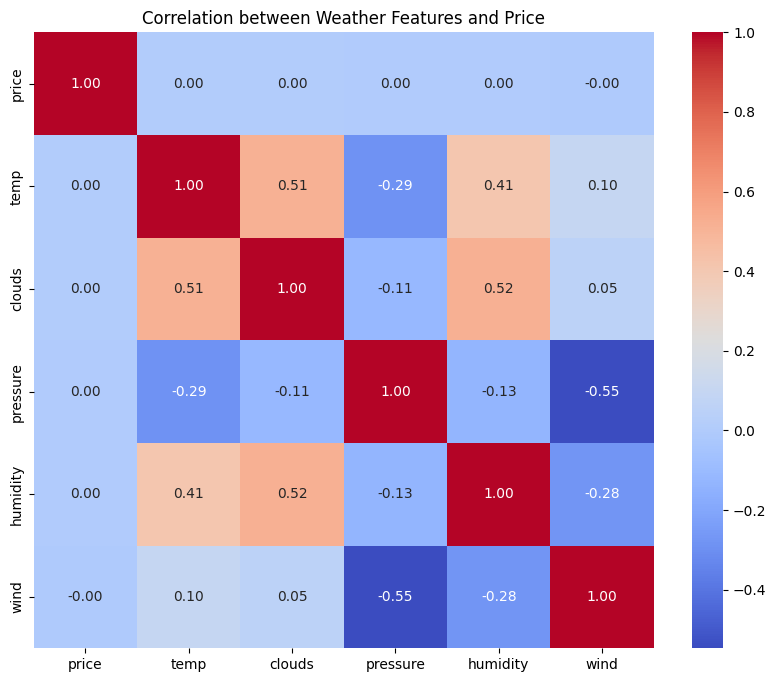

In [16]:
# Visualization 4 (Price vs weather conditions (heatmap)

# Join the cab_data and weather_data on time_stamp
combined_data = uber_df.join(
    weather_df,
    uber_df["uber_time_stamp"] == weather_df["weather_time_stamp"]
).filter(uber_df["source"] == weather_df["location"])

# Select relevant columns for correlation
correlation_columns = ['price', 'temp', 'clouds', 'pressure', 'humidity', 'wind']
selected_data = combined_data.select(*correlation_columns)

# Convert to Pandas for correlation calculation
correlation_data_pd = selected_data.toPandas()

# Compute correlation matrix
correlation_matrix = correlation_data_pd.corr()

# Plot heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Weather Features and Price')
plt.show()

In [ ]:
combined_data = uber_df.join(
    weather_df,
    uber_df["time_stamp"] == weather_df["time_stamp"]
).filter(uber_df["source"] == weather_df["location"])

combined_data.show()

In [ ]:
# Get the number of rows in the DataFrame
row_count = combined_data.count()

# Print the result
print(f"Number of rows in uber_df: {row_count}")


In [17]:
from pyspark.sql.functions import col, to_timestamp, date_trunc, round, hour

# Convert time_stamp to timestamp type in both DataFrames
# uber_df = uber_df.withColumn("time_stamp", to_timestamp(col("time_stamp")))
# weather_df = weather_df.withColumn("time_stamp", to_timestamp(col("time_stamp")))

# uber_df = uber_df.withColumnRenamed("time_stamp", "uber_time_stamp")
# weather_df = weather_df.withColumnRenamed("time_stamp", "weather_time_stamp")

# Join on rounded_time_stamp and source = location
combined_data = uber_df.join(
    weather_df,
    (uber_df["uber_time_stamp"] == weather_df["weather_time_stamp"]) & 
    (uber_df["source"] == weather_df["location"]),
    "left"
)

# Show the resulting DataFrame
combined_data.show()

+--------+--------+-------------------+------------------+-------------+-----+----------------+------+--------+-----+-------------+------+--------+----+-------------------+--------+-----+
|distance|cab_type|    uber_time_stamp|       destination|       source|price|surge_multiplier|    id|    name| temp|     location|clouds|pressure|rain| weather_time_stamp|humidity| wind|
+--------+--------+-------------------+------------------+-------------+-----+----------------+------+--------+-----+-------------+------+--------+----+-------------------+--------+-----+
|    0.94|    Uber|2018-11-28 23:30:00|         North End|North Station|  4.5|             1.0| 39765|UberPool|38.48|North Station|  0.57|  997.65| 0.0|2018-11-28 23:30:00|     0.7|10.02|
|    0.94|    Uber|2018-12-14 19:30:00|         North End|North Station|  4.5|             1.0|437984|UberPool|37.86|North Station|  0.61|  999.88| 0.0|2018-12-14 19:30:00|     0.7|10.01|
|    0.63|    Uber|2018-11-27 21:30:00|Financial District|So

In [12]:
# Get the number of rows in the DataFrame
row_count = combined_data.count()

# Print the result
print(f"Number of rows in uber_df: {row_count}")

Number of rows in uber_df: 330568


In [19]:
from pyspark.sql.functions import col, coalesce, last
from pyspark.sql.window import Window

# Replace NULL values in 'location' with values from 'source'
combined_data = combined_data.withColumn("location", coalesce(col("location"), col("source")))

# Define a window specification for forward-filling weather data
window_spec = (
    Window.partitionBy("location")
    .orderBy("weather_time_stamp")
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)
)

# Forward-fill missing weather-related columns
weather_columns = ["temp", "clouds", "pressure", "rain", "humidity", "wind"]

for column in weather_columns:
    combined_data = combined_data.withColumn(
        f"filled_{column}", last(col(column), ignorenulls=True).over(window_spec)
    )

# Replace original columns with filled columns
for column in weather_columns:
    combined_data = combined_data.drop(column).withColumnRenamed(f"filled_{column}", column)

# Show the updated DataFrame
combined_data.show()

Py4JJavaError: An error occurred while calling o270.showString.
: com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.rpc.UnauthenticatedException: com.google.cloud.spark.bigquery.repackaged.io.grpc.StatusRuntimeException: UNAUTHENTICATED: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.rpc.ApiExceptionFactory.createException(ApiExceptionFactory.java:71)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.grpc.GrpcApiExceptionFactory.create(GrpcApiExceptionFactory.java:72)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.grpc.GrpcApiExceptionFactory.create(GrpcApiExceptionFactory.java:60)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.grpc.GrpcExceptionCallable$ExceptionTransformingFuture.onFailure(GrpcExceptionCallable.java:97)
	at com.google.cloud.spark.bigquery.repackaged.com.google.api.core.ApiFutures$1.onFailure(ApiFutures.java:68)
	at com.google.cloud.spark.bigquery.repackaged.com.google.common.util.concurrent.Futures$CallbackListener.run(Futures.java:1074)
	at com.google.cloud.spark.bigquery.repackaged.com.google.common.util.concurrent.DirectExecutor.execute(DirectExecutor.java:30)
	at com.google.cloud.spark.bigquery.repackaged.com.google.common.util.concurrent.AbstractFuture.executeListener(AbstractFuture.java:1213)
	at com.google.cloud.spark.bigquery.repackaged.com.google.common.util.concurrent.AbstractFuture.complete(AbstractFuture.java:983)
	at com.google.cloud.spark.bigquery.repackaged.com.google.common.util.concurrent.AbstractFuture.setException(AbstractFuture.java:771)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.stub.ClientCalls$GrpcFuture.setException(ClientCalls.java:564)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.stub.ClientCalls$UnaryStreamToFuture.onClose(ClientCalls.java:534)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.internal.DelayedClientCall$DelayedListener$3.run(DelayedClientCall.java:463)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.internal.DelayedClientCall$DelayedListener.delayOrExecute(DelayedClientCall.java:427)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.internal.DelayedClientCall$DelayedListener.onClose(DelayedClientCall.java:460)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.internal.ClientCallImpl.closeObserver(ClientCallImpl.java:562)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.internal.ClientCallImpl.access$300(ClientCallImpl.java:70)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.internal.ClientCallImpl$ClientStreamListenerImpl$1StreamClosed.runInternal(ClientCallImpl.java:743)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.internal.ClientCallImpl$ClientStreamListenerImpl$1StreamClosed.runInContext(ClientCallImpl.java:722)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.internal.ContextRunnable.run(ContextRunnable.java:37)
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.internal.SerializingExecutor.run(SerializingExecutor.java:133)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
	Suppressed: com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.rpc.AsyncTaskException: Asynchronous task failed
		at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.rpc.ApiExceptions.callAndTranslateApiException(ApiExceptions.java:57)
		at com.google.cloud.spark.bigquery.repackaged.com.google.api.gax.rpc.UnaryCallable.call(UnaryCallable.java:112)
		at com.google.cloud.spark.bigquery.repackaged.com.google.cloud.bigquery.storage.v1.BigQueryReadClient.createReadSession(BigQueryReadClient.java:232)
		at com.google.cloud.spark.bigquery.direct.DirectBigQueryRelation.buildScan(DirectBigQueryRelation.scala:141)
		at org.apache.spark.sql.execution.datasources.DataSourceStrategy$.$anonfun$apply$4(DataSourceStrategy.scala:340)
		at org.apache.spark.sql.execution.datasources.DataSourceStrategy$.$anonfun$pruneFilterProject$1(DataSourceStrategy.scala:374)
		at org.apache.spark.sql.execution.datasources.DataSourceStrategy$.pruneFilterProjectRaw(DataSourceStrategy.scala:453)
		at org.apache.spark.sql.execution.datasources.DataSourceStrategy$.pruneFilterProject(DataSourceStrategy.scala:373)
		at org.apache.spark.sql.execution.datasources.DataSourceStrategy$.apply(DataSourceStrategy.scala:340)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$1(QueryPlanner.scala:63)
		at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
		at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
		at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:93)
		at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:70)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$3(QueryPlanner.scala:78)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
		at scala.collection.Iterator.foreach(Iterator.scala:943)
		at scala.collection.Iterator.foreach$(Iterator.scala:943)
		at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
		at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
		at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
		at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$2(QueryPlanner.scala:75)
		at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
		at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:93)
		at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:70)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$3(QueryPlanner.scala:78)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
		at scala.collection.Iterator.foreach(Iterator.scala:943)
		at scala.collection.Iterator.foreach$(Iterator.scala:943)
		at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
		at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
		at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
		at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$2(QueryPlanner.scala:75)
		at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
		at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:93)
		at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:70)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$3(QueryPlanner.scala:78)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
		at scala.collection.Iterator.foreach(Iterator.scala:943)
		at scala.collection.Iterator.foreach$(Iterator.scala:943)
		at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
		at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
		at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
		at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$2(QueryPlanner.scala:75)
		at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
		at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:93)
		at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:70)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$3(QueryPlanner.scala:78)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
		at scala.collection.Iterator.foreach(Iterator.scala:943)
		at scala.collection.Iterator.foreach$(Iterator.scala:943)
		at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
		at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
		at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
		at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$2(QueryPlanner.scala:75)
		at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
		at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:93)
		at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:70)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$3(QueryPlanner.scala:78)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
		at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
		at scala.collection.Iterator.foreach(Iterator.scala:943)
		at scala.collection.Iterator.foreach$(Iterator.scala:943)
		at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
		at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
		at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
		at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$2(QueryPlanner.scala:75)
		at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
		at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
		at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:93)
		at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:70)
		at org.apache.spark.sql.execution.QueryExecution$.createSparkPlan(QueryExecution.scala:496)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$sparkPlan$1(QueryExecution.scala:171)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:138)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:219)
		at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:219)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
		at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:218)
		at org.apache.spark.sql.execution.QueryExecution.sparkPlan$lzycompute(QueryExecution.scala:171)
		at org.apache.spark.sql.execution.QueryExecution.sparkPlan(QueryExecution.scala:164)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executedPlan$1(QueryExecution.scala:186)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:138)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:219)
		at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:219)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
		at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:218)
		at org.apache.spark.sql.execution.QueryExecution.executedPlan$lzycompute(QueryExecution.scala:186)
		at org.apache.spark.sql.execution.QueryExecution.executedPlan(QueryExecution.scala:179)
		at org.apache.spark.sql.execution.QueryExecution.simpleString(QueryExecution.scala:238)
		at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$explainString(QueryExecution.scala:284)
		at org.apache.spark.sql.execution.QueryExecution.explainString(QueryExecution.scala:252)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:117)
		at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
		at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
		at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
		at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
		at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
		at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
		at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
		at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
		at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
		at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
		at java.base/java.lang.reflect.Method.invoke(Method.java:566)
		at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
		at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
		at py4j.Gateway.invoke(Gateway.java:282)
		at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
		at py4j.commands.CallCommand.execute(CallCommand.java:79)
		at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
		at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
		... 1 more
Caused by: com.google.cloud.spark.bigquery.repackaged.io.grpc.StatusRuntimeException: UNAUTHENTICATED: Request had invalid authentication credentials. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.
	at com.google.cloud.spark.bigquery.repackaged.io.grpc.Status.asRuntimeException(Status.java:535)
	... 13 more


In [ ]:
# Get the number of rows in the DataFrame
row_count = combined_data.count()

# Print the result
print(f"Number of rows in uber_df: {row_count}")